# Проект: вариант 1

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from scipy.stats import norm

import requests 
from urllib.parse import urlencode

In [2]:
# Загрузим наши данные с Яндекс-диска:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

public_key = 'https://disk.yandex.ru/d/4lq_u9NdA2ZKtg'
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href']

In [3]:
df2 = pd.read_csv(download_url, sep=';')
df2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
# Проверим данные по ARPU из условия задачи
arpu_a = df2.query('testgroup=="a"').revenue.sum()/df2.query('testgroup=="a"').user_id.count()
arpu_b = df2.query('testgroup=="b"').revenue.sum()/df2.query('testgroup=="b"').user_id.count()
print('ARPU контрольной группы:', round(arpu_a,2) )
print('ARPU тестовой группы   :', round(arpu_b,2) )

ARPU контрольной группы: 25.41
ARPU тестовой группы   : 26.75


In [5]:
print('Разница между выборками', round((arpu_b-arpu_a)/arpu_a*100, 2), '%')

Разница между выборками 5.26 %


Пока всё сходится

In [6]:
# посмотрим базовую статистику по нашим данным
df2.groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
b,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


In [7]:
# видим, что много данных с нулевой выручкой, посмотрим распределение для ненулевых значений:
df2.query('revenue !=0').groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,1928.0,2663.998444,9049.039763,200.0,257.0,311.0,361.0,37433.0
b,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


<AxesSubplot:xlabel='revenue', ylabel='testgroup'>

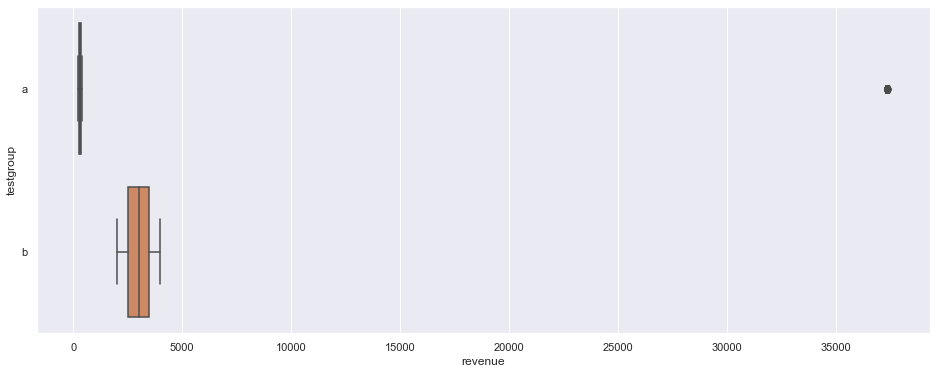

In [8]:
# Уже понятнее, видим большую разницу в максимальных значениях revenue, теперь посмотрим на данные глазами:
sns.set(rc={'figure.figsize':(16,6)})
sns.boxplot(data=df2.query('revenue !=0'), y='testgroup', x='revenue')

В контрольной группе виден явный **выброс** в виде продаж с высоким чеком, что может привести нас к некорректным выводам.

In [9]:
# посмотрим сколько у нас продаж больше 35000:
print('Продаж дороже 35000:', df2.query('revenue > 35000').revenue.count())
print('Продаж больше нуля :', df2.query('revenue > 0').revenue.count())
print('Покупок всего      :', df2.revenue.count())

Продаж дороже 35000: 123
Продаж больше нуля : 3733
Покупок всего      : 404770


<AxesSubplot:xlabel='revenue', ylabel='testgroup'>

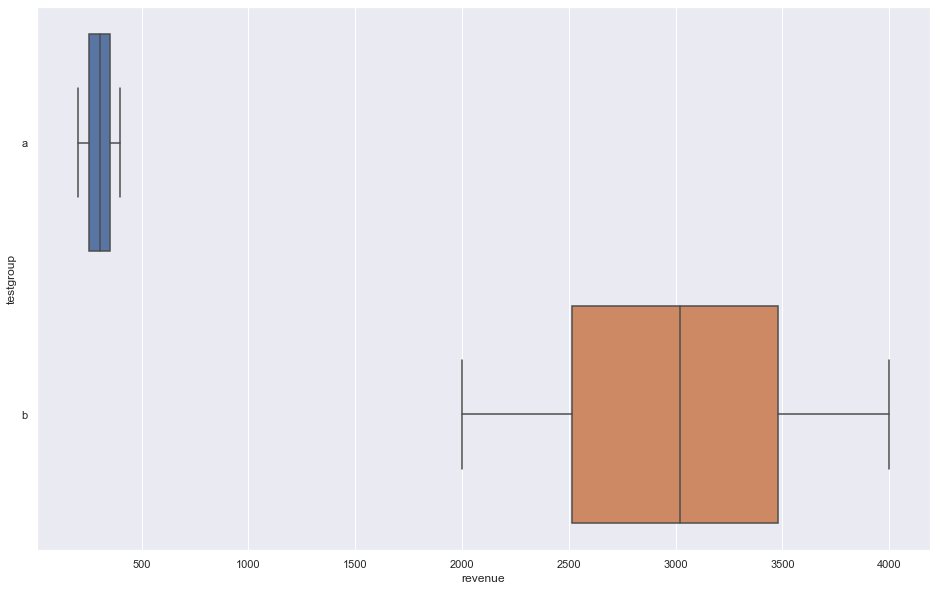

In [10]:
# уберем 123 продажи с высоким чеком, а также нулевые продажи и посмотрим еще раз
sns.set(rc={'figure.figsize':(16,10)})
sns.boxplot(data=df2.query('0 < revenue < 35000'), y='testgroup', x='revenue')

В таком виде разница видна уже на графике, можно даже не прибегать к статистическим методам. Но давайте сравним данные бутстрапом, для этого будем использовать функцию bootstrap из наших лекций.

In [11]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

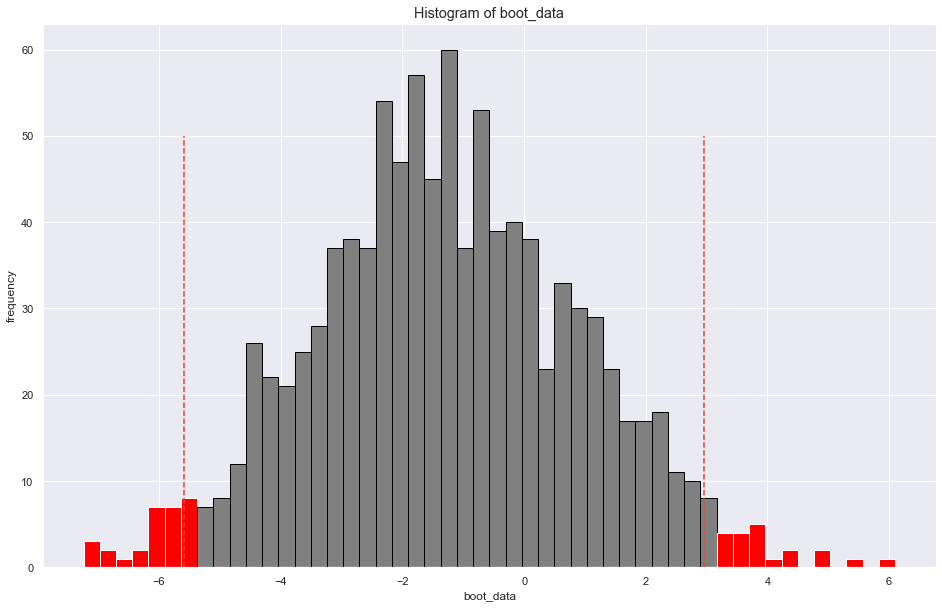

In [12]:
# Сначала сравним наши выборки без учета выброса и с нулевыми значениями:
booted_data = get_bootstrap(
                            df2.query('testgroup == "a" ').revenue,
                            df2.query('testgroup == "b" ').revenue
                           )

Видим, что при сравнении "в лоб" результаты теста говорят о статистически незначительной разнице между выборками(Ноль на графике попадает в доверительный интевал). Теперь попробуем убрать нулевые транзации:

  0%|          | 0/1000 [00:00<?, ?it/s]

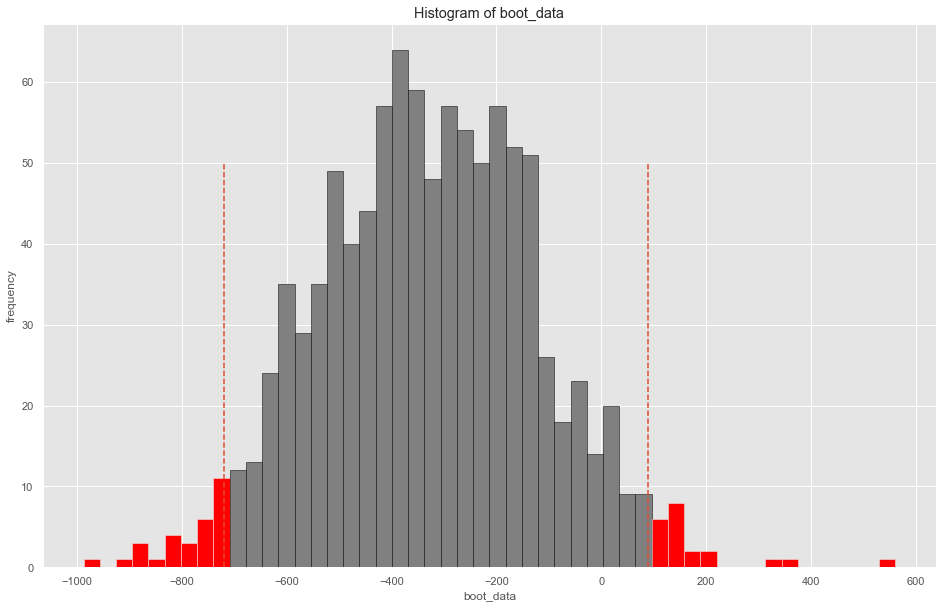

In [13]:
booted_data = get_bootstrap(
                            df2.query('testgroup == "a" & revenue > 0').revenue,
                            df2.query('testgroup == "b" & revenue > 0').revenue
                           )

Видим смещение ноля в ближе к границе доверительного интервала, но мы всё еще не может сказать о статистически значимых различиях между выборками. Наконец, уберем наш выброс:

  0%|          | 0/1000 [00:00<?, ?it/s]

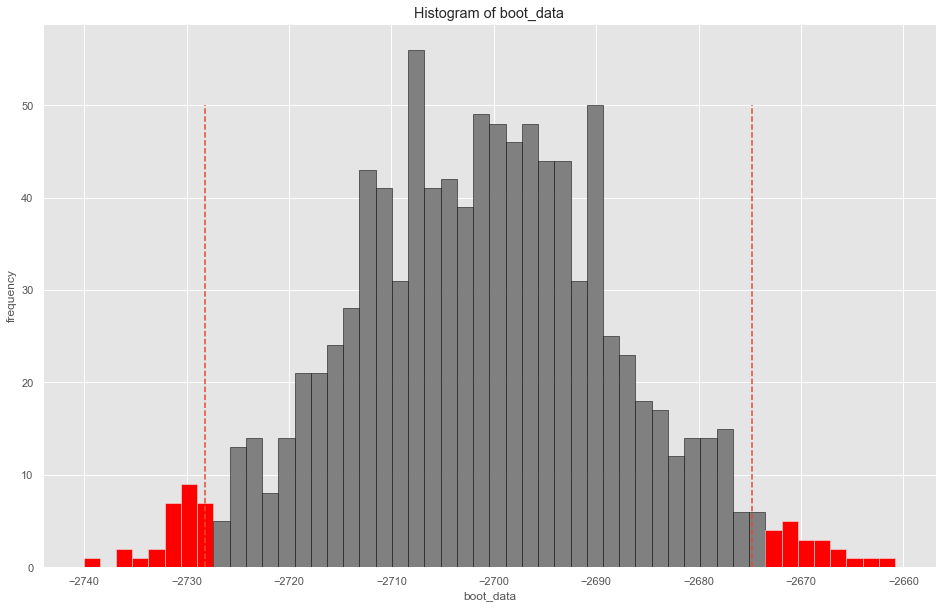

In [14]:
booted_data = get_bootstrap(
                            df2.query('testgroup == "a" & 0 < revenue < 35000').revenue,
                            df2.query('testgroup == "b" & revenue > 0'        ).revenue
                           )

Ноль ушел далеко за пределы доверительных интервалов!

In [15]:
print('P-value:')
booted_data["p_value"]

P-value:


0.0

P-value меньше 0.05, что подтверждает нашу гипотезу о различии двух выборок

In [16]:
print('Квантили:')
booted_data["quants"]

Квантили:


,0
0.025,-2728.198380
0.975,-2674.755125


**Выводы**

Главный вывод, который можно сделать - наши выброки по результатам А/Б-теста **статистически различаются**.

Тем не менее остается открытым вопрос о 123 продажах с высоким чеком в контрольной выборке. Необходимо обраратиться в отдел продаж для уточнения - действительно ли эти транзакции попали в наш тест случайно или такие же результаты ожидались и в тестовой выборке? Если ожидались, то статистических различий между выборками не будет.